# Chaper 2 - N-armed Bandits
### Deep Reinforcement Learning _in Action_

##### Listing 2.1

In [36]:
def get_best_action(actions):
	best_action = 0
	max_action_value = 0
	for i in range(len(actions)): #A 
		cur_action_value = get_action_value(actions[i]) #B
		if cur_action_value > max_action_value:
			best_action = i
			max_action_value = cur_action_value
	return best_action

##### Listing 2.2

In [37]:
import numpy as np
from scipy import stats
import random
import matplotlib.pyplot as plt

n = 10
probs = np.random.rand(n) #A
eps = 0.1

##### Listing 2.3

In [39]:
def get_reward(prob, n=10):
    reward = 0;
    for i in range(n):
        if random.random() < prob:
            reward += 1
    return reward

In [40]:
reward_test = [get_reward(0.7) for _ in range(2000)]

In [41]:
np.mean(reward_test)

6.9945

In [42]:
sum = 0
x = [4,5,6,7]
for j in range(len(x)): 
	sum = sum + x[j]
sum

22

(array([  1.,   2.,  24.,  71., 228., 380., 531., 438., 325.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 9 Patch objects>)

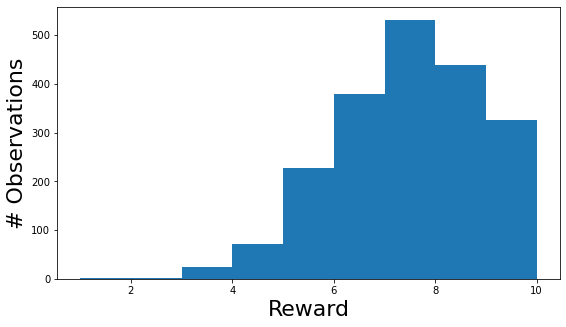

In [43]:
plt.figure(figsize=(9,5))
plt.xlabel("Reward",fontsize=22)
plt.ylabel("# Observations",fontsize=22)
plt.hist(reward_test,bins=9)

##### Listing 2.4

In [56]:
# 10 actions x 2 columns
# Columns: Count #, Avg Reward
record = np.zeros((n,2))

In [57]:
def get_best_arm(record):
    arm_index = np.argmax(record[:,1],axis=0)
    return arm_index

In [58]:
def update_record(record,action,r):
    new_r = (record[action,0] * record[action,1] + r) / (record[action,0] + 1)
    record[action,0] += 1
    record[action,1] = new_r
    return record

##### Listing 2.5

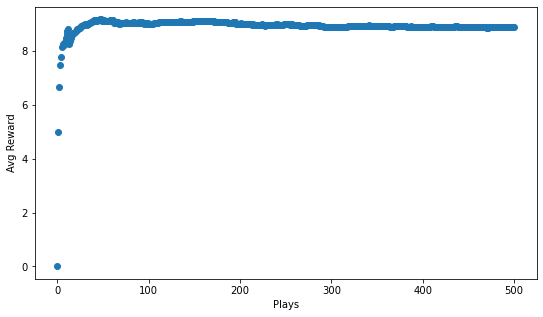

In [60]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
fig.set_size_inches(9,5)
rewards = [0]
for i in range(500):
    if random.random() > 0.1*((500-i)/500):
        choice = get_best_arm(record)
    else:
        choice = np.random.randint(10)
    r = get_reward(probs[choice])
    record = update_record(record,choice,r)
    mean_reward = ((i+1) * rewards[-1] + r)/(i+2)
    rewards.append(mean_reward)
ax.scatter(np.arange(len(rewards)),rewards)

##### Listing 2.6

In [61]:
def softmax(av, tau=1.12):
    softm = ( np.exp(av / tau) / np.sum( np.exp(av / tau) ) )
    return softm

In [76]:
probs = np.random.rand(n)
record = np.zeros((n,2))

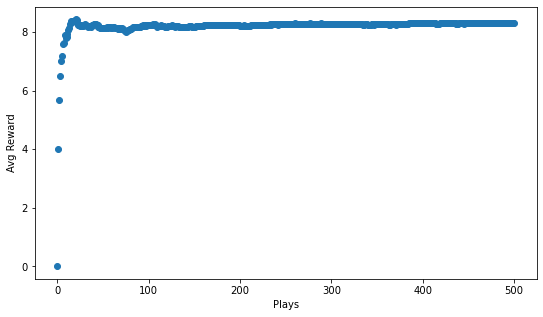

In [78]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
fig.set_size_inches(9,5)
rewards = [0]
for i in range(500):
    if i<300:
        p = softmax(record[:,1],tau=0.7)
    else:
        p = softmax(record[:,1],tau=0.05)  
    #print(p)
    choice = np.random.choice(np.arange(n),p=p)
    #print(choice)
    r = get_reward(probs[choice])
    #print(r)
    record = update_record(record,choice,r)
    mean_reward = ((i+1) * rewards[-1] + r)/(i+2)
    rewards.append(mean_reward)
ax.scatter(np.arange(len(rewards)),rewards)

##### Listing 2.9

In [79]:
class ContextBandit:
    def __init__(self, arms=10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
        
    def init_distribution(self, arms):
        # Num states = Num Arms to keep things simple
        self.bandit_matrix = np.random.rand(arms,arms)
        #each row represents a state, each column an arm
        
    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward
        
    def get_state(self):
        return self.state
    
    def update_state(self):
        self.state = np.random.randint(0,self.arms)
        
    def get_reward(self,arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
        
    def choose_arm(self, arm):
        reward = self.get_reward(arm)
        self.update_state()
        return reward

In [80]:
import numpy as np
import torch

arms = 10
N, D_in, H, D_out = 1, arms, 100, arms

In [81]:
env = ContextBandit(arms=10)
state = env.get_state()
reward = env.choose_arm(1)
print(state)

9


In [82]:
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.ReLU(),
    torch.nn.Linear(H, D_out),
    torch.nn.ReLU(),
)

In [105]:
loss_fn = torch.nn.MSELoss()

In [144]:
env = ContextBandit(arms)

In [145]:
def one_hot(N, pos, val=1):
    one_hot_vec = np.zeros(N)
    one_hot_vec[pos] = val
    return one_hot_vec

In [146]:
one_hot(10,5)


array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [147]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

In [148]:
def train(env, epochs=5000, learning_rate=1e-2):
    cur_state = torch.Tensor(one_hot(arms,env.get_state())) #A
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    rewards = []
    for i in range(epochs):
        print(cur_state)
        y_pred = model(cur_state) #B
        print(y_pred.data)
        if i<4000:
            av_softmax = softmax(y_pred.data.numpy(), tau=5) #C
        else:
            av_softmax = softmax(y_pred.data.numpy(), tau=0.2) #C            
        av_softmax /= av_softmax.sum() #D
        #print(av_softmax)
        choice = np.random.choice(arms, p=av_softmax) #E
        print(choice)
        cur_reward = env.choose_arm(choice) #F
        print(cur_reward)
        one_hot_reward = y_pred.data.numpy().copy() #G
        print(one_hot_reward)
        one_hot_reward[choice] = cur_reward #H
        print(one_hot_reward)
        reward = torch.Tensor(one_hot_reward)
        rewards.append(cur_reward)
        loss = loss_fn(y_pred, reward)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cur_state = torch.Tensor(one_hot(arms,env.get_state())) #I
    return np.array(rewards)

In [149]:
rewards = train(env)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([8.3973, 9.9922, 5.4329, 7.4511, 7.3147, 0.0000, 0.0000, 3.6173, 8.6886,
        6.0369])
1
1
[8.397291  9.992213  5.432853  7.4510956 7.3147254 0.        0.
 3.6173015 8.688608  6.0369425]
[8.397291  1.        5.432853  7.4510956 7.3147254 0.        0.
 3.6173015 8.688608  6.0369425]
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([1.2184, 4.6128, 2.1948, 8.9924, 9.9429, 0.0000, 0.0000, 7.5224, 4.8975,
        3.3290])
8
3
[1.2184461 4.6128497 2.1947947 8.992422  9.942914  0.        0.
 7.5224094 4.8975472 3.328951 ]
[1.2184461 4.6128497 2.1947947 8.992422  9.942914  0.        0.
 7.5224094 3.        3.328951 ]
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([6.5274, 8.7101, 5.2533, 2.1451, 1.1551, 0.0000, 0.0000, 2.6080, 2.6853,
        6.9563])
2
5
[6.5274353 8.710075  5.2532706 2.145093  1.1551194 0.        0.
 2.6080003 2.6853437 6.9563313]
[6.5274353 8.710075  5.        2.145093  1.1551194 0.        0.
 2.608

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([8.8854, 7.8287, 5.2777, 5.7895, 5.8076, 0.0000, 0.0000, 3.9502, 7.4214,
        6.1366])
1
2
[8.885363  7.828713  5.2777386 5.789519  5.80759   0.        0.
 3.9501534 7.4214244 6.136598 ]
[8.885363  2.        5.2777386 5.789519  5.80759   0.        0.
 3.9501534 7.4214244 6.136598 ]
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([2.6614, 4.8736, 2.1336, 1.5099, 6.7952, 0.0000, 0.0000, 5.9050, 1.9190,
        3.9842])
1
2
[2.6613522 4.873637  2.1336427 1.5099169 6.7952003 0.        0.
 5.9050455 1.9190269 3.9842443]
[2.6613522 2.        2.1336427 1.5099169 6.7952003 0.        0.
 5.9050455 1.9190269 3.9842443]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([8.9057, 7.7308, 5.2679, 5.7737, 5.7912, 0.0000, 0.0000, 3.9261, 7.3980,
        6.1284])
1
5
[8.905676  7.730753  5.267866  5.773655  5.7911673 0.        0.
 3.9260745 7.3980293 6.1284237]
[8.905676  5.        5.267866  5.773655  5.7911673 0.        0.
 3.926

tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([6.3616, 6.7753, 4.9766, 1.3045, 2.2248, 0.0000, 0.0000, 4.5575, 1.9774,
        7.8809])
0
7
[6.361581  6.775251  4.9766026 1.3044839 2.224844  0.        0.
 4.5575047 1.9774294 7.88088  ]
[7.        6.775251  4.9766026 1.3044839 2.224844  0.        0.
 4.5575047 1.9774294 7.88088  ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([9.0297, 6.4400, 4.7648, 4.2841, 6.3305, 0.0000, 0.0000, 4.9250, 6.3747,
        6.1926])
7
1
[9.029711  6.4400406 4.7647715 4.284101  6.3305125 0.        0.
 4.925029  6.374671  6.1926184]
[9.029711  6.4400406 4.7647715 4.284101  6.3305125 0.        0.
 1.        6.374671  6.1926184]
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([6.4043, 6.7926, 4.9878, 1.3008, 2.2315, 0.0000, 0.0000, 4.5938, 2.0193,
        7.9156])
2
7
[6.4043365 6.7926326 4.9877696 1.300756  2.2314818 0.        0.
 4.5937576 2.019315  7.915559 ]
[6.4043365 6.7926326 7.        1.300756  2.2314818 0.        0.
 4.593

8
[9.485364  6.8409615 4.623275  4.377622  6.431016  0.        0.
 4.4265547 6.5655537 6.7325606]
[8.        6.8409615 4.623275  4.377622  6.431016  0.        0.
 4.4265547 6.5655537 6.7325606]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([5.7501, 7.8945, 3.4632, 4.3558, 7.8781, 0.0000, 0.0000, 7.0624, 3.4595,
        5.4845])
0
7
[5.7501287 7.894476  3.4631686 4.355798  7.8781433 0.        0.
 7.0623827 3.4595375 5.4844666]
[7.        7.894476  3.4631686 4.355798  7.8781433 0.        0.
 7.0623827 3.4595375 5.4844666]
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([5.1117, 2.0638, 2.6948, 4.3327, 4.1348, 0.0000, 0.0000, 8.4472, 3.9439,
        6.6288])
9
3
[5.1116967 2.0638463 2.6947613 4.3326745 4.134773  0.        0.
 8.447177  3.9438863 6.6288114]
[5.1116967 2.0638463 2.6947613 4.3326745 4.134773  0.        0.
 8.447177  3.9438863 3.       ]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([5.7740, 7.9212, 3.4845, 4.3602, 7.9090, 0.0000, 0.0000, 7.0849, 3

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([5.5128, 5.1160, 3.2060, 0.0000, 7.4354, 0.0000, 0.0000, 5.7848, 4.2637,
        7.2987])
8
3
[5.512818  5.116003  3.2060046 0.        7.4353743 0.        0.
 5.7847576 4.263673  7.298671 ]
[5.512818  5.116003  3.2060046 0.        7.4353743 0.        0.
 5.7847576 3.        7.298671 ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([8.9024, 4.4286, 7.3693, 2.7818, 8.7340, 0.0000, 0.0000, 5.2025, 4.8021,
        7.4661])
9
6
[8.902443  4.4286356 7.3692694 2.7818081 8.733998  0.        0.
 5.202463  4.8021193 7.4660883]
[8.902443  4.4286356 7.3692694 2.7818081 8.733998  0.        0.
 5.202463  4.8021193 6.       ]
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([4.3887, 3.0307, 7.9367, 0.0000, 1.4101, 0.0000, 0.0000, 6.2035, 1.2048,
        8.3985])
0
9
[4.388697  3.030733  7.936673  0.        1.4101226 0.        0.
 6.203499  1.2048167 8.398537 ]
[9.        3.030733  7.936673  0.        1.4101226 0.        0.
 6.203

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([10.6644,  5.6902,  4.4723,  3.7239,  7.8590,  0.0000,  0.0000,  4.7037,
         8.1610,  7.3416])
5
4
[10.664406   5.690225   4.4722643  3.7239037  7.8589945  0.
  0.         4.7036777  8.1609955  7.341561 ]
[10.664406   5.690225   4.4722643  3.7239037  7.8589945  4.
  0.         4.7036777  8.1609955  7.341561 ]
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([6.5170, 4.4759, 2.6926, 0.0000, 6.8426, 0.0000, 0.0000, 6.1085, 5.1451,
        8.3113])
1
4
[6.517047  4.475947  2.6926188 0.        6.842624  0.        0.
 6.108485  5.145131  8.311261 ]
[6.517047  4.        2.6926188 0.        6.842624  0.        0.
 6.108485  5.145131  8.311261 ]
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([5.0467, 1.9173, 3.6054, 3.2364, 4.4310, 0.0000, 0.0000, 9.4959, 4.1422,
        5.4106])
9
5
[5.0466757 1.9173137 3.6054323 3.2363834 4.4309807 0.        0.
 9.495927  4.142249  5.410614 ]
[5.0466757 1.9173137 3.6054323 3.2363834

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([1.6808, 3.0338, 2.6495, 4.0752, 5.8723, 0.0000, 0.0000, 6.0858, 2.9183,
        2.5832])
4
8
[1.6807781 3.0337749 2.6494677 4.0752306 5.8722844 0.        0.
 6.0858126 2.918254  2.5832093]
[1.6807781 3.0337749 2.6494677 4.0752306 8.        0.        0.
 6.0858126 2.918254  2.5832093]
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([3.1856, 4.5202, 2.3498, 1.0740, 7.4483, 0.0000, 0.0000, 7.0376, 1.7141,
        3.6040])
5
1
[3.1856256 4.5202017 2.3497515 1.0739762 7.4482975 0.        0.
 7.0375805 1.7141258 3.6039538]
[3.1856256 4.5202017 2.3497515 1.0739762 7.4482975 1.        0.
 7.0375805 1.7141258 3.6039538]
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([1.6824, 3.0569, 2.6495, 4.0960, 5.9467, 0.0000, 0.0000, 6.1403, 2.9395,
        2.5853])
5
1
[1.682373  3.0569136 2.6494665 4.0959587 5.946722  0.        0.
 6.140282  2.9394855 2.5852695]
[1.682373  3.0569136 2.6494665 4.0959587 5.946722  1.        0.
 6.140

 6.199087  2.7436557 2.5347834]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([9.0024, 5.9065, 4.4158, 2.8111, 6.1316, 0.0000, 0.0000, 3.7142, 7.0567,
        7.9719])
4
9
[9.00243   5.906465  4.415845  2.8111036 6.1315837 0.        0.
 3.7142036 7.0566792 7.9718695]
[9.00243   5.906465  4.415845  2.8111036 9.        0.        0.
 3.7142036 7.0566792 7.9718695]
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([5.2687, 4.3510, 9.0518, 0.0000, 0.3363, 0.0000, 0.0000, 7.3639, 0.6477,
        9.3912])
2
8
[5.2686863  4.3509703  9.051758   0.         0.33627486 0.
 0.         7.363917   0.64774996 9.391174  ]
[5.2686863  4.3509703  8.         0.         0.33627486 0.
 0.         7.363917   0.64774996 9.391174  ]
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([4.3322, 3.8698, 3.3811, 3.5843, 4.7892, 0.0000, 0.0000, 8.6790, 3.6838,
        4.8800])
6
2
[4.332238  3.869801  3.3810735 3.5843391 4.789229  0.        0.
 8.678954  3.6838045 4.880044 ]
[4.332238  3.869801 

tensor([6.2895, 6.0952, 6.1417, 1.8767, 5.1228, 0.0000, 0.0000, 6.2292, 2.3808,
        8.6421])
2
7
[6.289528  6.0952454 6.141737  1.8767393 5.122819  0.        0.
 6.2292223 2.3807828 8.642073 ]
[6.289528  6.0952454 7.        1.8767393 5.122819  0.        0.
 6.2292223 2.3807828 8.642073 ]
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([5.5529, 4.7454, 8.4838, 0.0000, 0.6080, 0.0000, 0.0000, 7.6372, 0.7236,
        9.6061])
5
4
[5.552886  4.7454314 8.4838295 0.        0.6079551 0.        0.
 7.6371727 0.7235611 9.606127 ]
[5.552886  4.7454314 8.4838295 0.        0.6079551 4.        0.
 7.6371727 0.7235611 9.606127 ]
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([3.4713, 4.8183, 3.4453, 1.7490, 8.3904, 0.0000, 0.0000, 8.4909, 1.1600,
        3.7714])
7
10
[3.4712915 4.818283  3.44531   1.7489644 8.390363  0.        0.
 8.490861  1.1599514 3.7714298]
[ 3.4712915  4.818283   3.44531    1.7489644  8.390363   0.
  0.        10.         1.1599514  3.7714298]
tensor([0., 

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([5.7747, 9.6960, 4.9087, 4.8476, 8.0213, 0.0000, 0.0000, 7.1043, 1.8788,
        2.4260])
6
3
[5.774707  9.695993  4.908657  4.847649  8.021251  0.        0.
 7.1043205 1.8787894 2.4259684]
[5.774707  9.695993  4.908657  4.847649  8.021251  0.        3.
 7.1043205 1.8787894 2.4259684]
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([6.4706, 4.1837, 6.3941, 0.9723, 5.5361, 0.0000, 0.0000, 9.6178, 5.2577,
        4.2061])
0
8
[6.4705706 4.183679  6.3940907 0.9722922 5.5361443 0.        0.
 9.617798  5.2576714 4.206113 ]
[8.        4.183679  6.3940907 0.9722922 5.5361443 0.        0.
 9.617798  5.2576714 4.206113 ]
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([2.0739, 4.0162, 2.4625, 5.4983, 7.2221, 0.0000, 0.0000, 5.2742, 3.8546,
        3.2116])
2
5
[2.0738573 4.016184  2.4625258 5.498268  7.222064  0.        0.
 5.2742004 3.854565  3.2115598]
[2.0738573 4.016184  5.        5.498268  7.222064  0.        0.
 5.274

 8.794419  4.284025  5.936097 ]
[10.         6.272085   6.3803988  3.0299518  8.5217705  0.
  0.         8.794419   4.284025   5.936097 ]
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([4.4031, 4.5613, 2.8105, 4.2874, 5.4785, 0.0000, 0.0000, 8.0113, 5.4504,
        5.4322])
6
1
[4.403077  4.561287  2.810547  4.2874007 5.4784756 0.        0.
 8.011306  5.450433  5.432184 ]
[4.403077  4.561287  2.810547  4.2874007 5.4784756 0.        1.
 8.011306  5.450433  5.432184 ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([9.9335, 5.4014, 3.0974, 2.2016, 6.8642, 0.0000, 0.0000, 3.7855, 9.7222,
        8.9639])
9
10
[9.933485  5.401374  3.0973568 2.2015817 6.8642097 0.        0.
 3.7855215 9.722246  8.963907 ]
[ 9.933485   5.401374   3.0973568  2.2015817  6.8642097  0.
  0.         3.7855215  9.722246  10.       ]
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([7.7321, 4.3557, 5.7747, 1.7659, 5.6621, 0.0000, 0.0000, 9.8171, 5.8527,
        4.1170])
7
10
[7.732118  4.355

tensor([8.5516, 5.5733, 6.0805, 3.0746, 7.8583, 0.0000, 0.0000, 8.5285, 4.2354,
        5.4014])
2
6
[8.551627  5.573328  6.080462  3.0745835 7.858349  0.        0.
 8.528518  4.2354374 5.4014244]
[8.551627  5.573328  6.        3.0745835 7.858349  0.        0.
 8.528518  4.2354374 5.4014244]
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([7.0036, 3.3968, 6.1286, 1.3869, 4.0803, 0.0000, 0.0000, 9.7339, 5.4132,
        3.6386])
2
5
[7.0036464 3.3968213 6.1285515 1.3868631 4.0802736 0.        0.
 9.733945  5.4132147 3.6385899]
[7.0036464 3.3968213 5.        1.3868631 4.0802736 0.        0.
 9.733945  5.4132147 3.6385899]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([9.1331, 4.6814, 2.9013, 1.8829, 6.2237, 0.0000, 0.0000, 3.5053, 9.5551,
        8.3562])
4
9
[9.133111  4.6814246 2.901303  1.8828559 6.223737  0.        0.
 3.5052896 9.555071  8.35619  ]
[9.133111  4.6814246 2.901303  1.8828559 9.        0.        0.
 3.5052896 9.555071  8.35619  ]
tensor([0., 0., 0., 0.,

        9.7978])
0
4
[5.8345985 4.4769983 3.0206566 0.        7.3659344 0.        0.
 6.242697  5.494787  9.797825 ]
[4.        4.4769983 3.0206566 0.        7.3659344 0.        0.
 6.242697  5.494787  9.797825 ]
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([5.7933, 4.4629, 3.0138, 0.0000, 7.3756, 0.0000, 0.0000, 6.2284, 5.4716,
        9.8113])
8
5
[5.79326   4.462928  3.0137734 0.        7.3755794 0.        0.
 6.2284336 5.471571  9.81135  ]
[5.79326   4.462928  3.0137734 0.        7.3755794 0.        0.
 6.2284336 5.        9.81135  ]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([5.9626, 9.2821, 4.4843, 4.3479, 8.2085, 0.0000, 0.0000, 6.7116, 2.6795,
        2.4194])
7
10
[5.962601  9.282061  4.4842606 4.347927  8.208531  0.        0.
 6.711644  2.6795337 2.4194033]
[ 5.962601   9.282061   4.4842606  4.347927   8.208531   0.
  0.        10.         2.6795337  2.4194033]
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([3.5967, 4.4436, 3.4808, 2.6145, 8.6

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([7.4307, 3.0145, 7.8608, 0.0000, 0.0000, 0.0000, 0.0000, 6.8047, 2.5099,
        8.9972])
1
2
[7.430685  3.0144982 7.860775  0.        0.        0.        0.
 6.804701  2.5099154 8.997206 ]
[7.430685  2.        7.860775  0.        0.        0.        0.
 6.804701  2.5099154 8.997206 ]
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([3.4562, 5.1936, 2.7144, 3.6423, 5.2748, 0.0000, 0.0000, 8.7447, 4.9224,
        4.8474])
4
8
[3.456229  5.193613  2.7144024 3.6422796 5.274827  0.        0.
 8.744708  4.9224343 4.847408 ]
[3.456229  5.193613  2.7144024 3.6422796 8.        0.        0.
 8.744708  4.9224343 4.847408 ]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([5.9205, 8.9285, 3.9790, 4.0246, 7.9246, 0.0000, 0.0000, 7.5226, 3.5747,
        2.9226])
7
6
[5.9205294 8.928501  3.978975  4.0246    7.9246283 0.        0.
 7.522627  3.5746834 2.92264  ]
[5.9205294 8.928501  3.978975  4.0246    7.9246283 0.        0.
 6.   

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([4.7991, 3.4683, 3.1632, 0.0000, 5.6051, 0.0000, 0.0000, 6.3674, 5.1981,
        8.6703])
5
6
[4.799072  3.4682872 3.1632042 0.        5.6050925 0.        0.
 6.367425  5.1981306 8.6703415]
[4.799072  3.4682872 3.1632042 0.        5.6050925 6.        0.
 6.367425  5.1981306 8.6703415]
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([6.0142, 3.0718, 6.0692, 0.0000, 2.0431, 0.0000, 0.0000, 9.6673, 3.8574,
        3.3103])
7
10
[6.0142384 3.0717754 6.0691557 0.        2.0431204 0.        0.
 9.66729   3.8573794 3.310267 ]
[ 6.0142384  3.0717754  6.0691557  0.         2.0431204  0.
  0.        10.         3.8573794  3.310267 ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([ 8.8615,  4.3505,  3.1827,  1.1142,  6.7251,  0.0000,  0.0000,  2.8774,
        10.2960,  9.3396])
0
9
[ 8.861496   4.350503   3.182735   1.1141589  6.7250547  0.
  0.         2.8773654 10.295999   9.339613 ]
[ 9.         4.350503   3.182735   1.11

tensor([3.0709, 3.7886, 4.1999, 2.7555, 8.2601, 0.0000, 0.0000, 8.2994, 1.8903,
        3.0287])
9
5
[3.0708566 3.7885575 4.1999016 2.7555485 8.260095  0.        0.
 8.299383  1.8902805 3.0287402]
[3.0708566 3.7885575 4.1999016 2.7555485 8.260095  0.        0.
 8.299383  1.8902805 5.       ]
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([3.0731, 3.7969, 4.1988, 2.7738, 8.2674, 0.0000, 0.0000, 8.3081, 1.8930,
        3.0465])
7
9
[3.073116  3.7969272 4.1987514 2.7738304 8.267434  0.        0.
 8.308096  1.8930118 3.0464618]
[3.073116  3.7969272 4.1987514 2.7738304 8.267434  0.        0.
 9.        1.8930118 3.0464618]
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([3.3987, 6.2440, 3.1368, 3.6034, 6.0426, 0.0000, 0.0000, 8.9752, 5.7454,
        5.2918])
9
7
[3.3987145 6.2439985 3.1368406 3.6033504 6.042557  0.        0.
 8.975167  5.745423  5.291753 ]
[3.3987145 6.2439985 3.1368406 3.6033504 6.042557  0.        0.
 8.975167  5.745423  7.       ]
tensor([0., 0., 0., 0.,

        6.7749])
0
4
[2.1987927 3.030338  2.4421985 3.1886692 6.6499825 0.        0.
 4.683935  6.4150496 6.7749386]
[4.        3.030338  2.4421985 3.1886692 6.6499825 0.        0.
 4.683935  6.4150496 6.7749386]
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([3.7021, 6.3327, 2.0654, 3.1866, 6.3711, 0.0000, 0.0000, 8.9638, 5.9807,
        5.7443])
8
9
[3.7020543 6.332699  2.06544   3.1865687 6.371132  0.        0.
 8.963804  5.9806957 5.7443447]
[3.7020543 6.332699  2.06544   3.1865687 6.371132  0.        0.
 8.963804  9.        5.7443447]
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([7.0398, 3.2580, 6.0650, 0.0000, 1.9285, 0.0000, 0.0000, 9.8634, 4.3524,
        3.5091])
0
9
[7.0397806 3.258016  6.065031  0.        1.9284638 0.        0.
 9.863359  4.35235   3.5091195]
[9.        3.258016  6.065031  0.        1.9284638 0.        0.
 9.863359  4.35235   3.5091195]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([8.5418, 5.0900, 6.0131, 2.8693, 6.8281, 0.0000

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([4.3300, 3.0849, 2.3987, 0.0000, 6.3175, 0.0000, 0.0000, 5.3051, 5.9292,
        8.0844])
0
5
[4.329994  3.0848894 2.3987176 0.        6.3175287 0.        0.
 5.3051124 5.929166  8.084376 ]
[5.        3.0848894 2.3987176 0.        6.3175287 0.        0.
 5.3051124 5.929166  8.084376 ]
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([6.3521, 3.8184, 6.0311, 2.5416, 8.2498, 0.0000, 0.0000, 7.4900, 4.3681,
        8.7014])
9
9
[6.352084  3.8183656 6.031145  2.5416188 8.249835  0.        0.
 7.489952  4.3681107 8.7013855]
[6.352084  3.8183656 6.031145  2.5416188 8.249835  0.        0.
 7.489952  4.3681107 9.       ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([8.4912, 3.9982, 3.4359, 0.7848, 7.1537, 0.0000, 0.0000, 2.4853, 9.7930,
        8.0043])
8
10
[8.491166   3.998163   3.4359055  0.78476983 7.1537213  0.
 0.         2.4852953  9.793011   8.004264  ]
[ 8.491166    3.998163    3.4359055   0.78476983  7.1537213 

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([6.5260, 3.9444, 7.2154, 0.1311, 2.5932, 0.0000, 0.0000, 9.8666, 3.5461,
        2.8678])
1
5
[6.5259914  3.944406   7.2153616  0.13113213 2.5932035  0.
 0.         9.866575   3.5460987  2.867776  ]
[6.5259914  5.         7.2153616  0.13113213 2.5932035  0.
 0.         9.866575   3.5460987  2.867776  ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([ 8.4901,  4.2315,  4.3287,  2.1256,  8.9423,  0.0000,  0.0000,  2.7734,
        10.0596,  9.0502])
4
8
[ 8.490119   4.23148    4.328666   2.1256437  8.942266   0.
  0.         2.7733755 10.059587   9.05022  ]
[ 8.490119   4.23148    4.328666   2.1256437  8.         0.
  0.         2.7733755 10.059587   9.05022  ]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([4.7412, 9.9902, 6.0718, 3.6711, 7.8518, 0.0000, 0.0000, 6.5340, 2.9690,
        2.2967])
3
4
[4.7412367 9.99024   6.0717716 3.6710515 7.8517747 0.        0.
 6.534008  2.9689524 2.2967176]
[4.7412367 9.99024   6

        5.8573])
4
6
[1.8380045 7.936097  2.7771626 4.7118587 8.448069  0.        0.
 8.763065  6.7702074 5.8572607]
[1.8380045 7.936097  2.7771626 4.7118587 6.        0.        0.
 8.763065  6.7702074 5.8572607]
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([4.0336, 2.0388, 3.3423, 0.0000, 6.0241, 0.0000, 0.0000, 4.4570, 4.8370,
        7.9705])
2
1
[4.033638  2.0388405 3.3422678 0.        6.024149  0.        0.
 4.4569683 4.836958  7.9704943]
[4.033638  2.0388405 1.        0.        6.024149  0.        0.
 4.4569683 4.836958  7.9704943]
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([1.8546, 7.9302, 2.8156, 4.6810, 8.3239, 0.0000, 0.0000, 8.7547, 6.7438,
        5.8625])
9
7
[1.8546371 7.930246  2.8156183 4.680999  8.323921  0.        0.
 8.754708  6.743847  5.8625374]
[1.8546371 7.930246  2.8156183 4.680999  8.323921  0.        0.
 8.754708  6.743847  7.       ]
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([8.3895, 2.0018, 7.0903, 0.0000, 0.0000, 0.0000

tensor([ 6.1406,  3.9336,  6.9621,  0.0000,  1.7960,  0.0000,  0.0000, 10.1570,
         2.9816,  2.3182])
7
10
[ 6.14064    3.9336238  6.96212    0.         1.7960466  0.
  0.        10.156965   2.981592   2.3182318]
[ 6.14064    3.9336238  6.96212    0.         1.7960466  0.
  0.        10.         2.981592   2.3182318]
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([2.5817, 4.1477, 3.7154, 5.0813, 8.8119, 0.0000, 0.0000, 8.5349, 2.0541,
        3.7079])
7
8
[2.5817115 4.147722  3.7153769 5.0813475 8.811898  0.        0.
 8.534892  2.0541198 3.7078762]
[2.5817115 4.147722  3.7153769 5.0813475 8.811898  0.        0.
 8.        2.0541198 3.7078762]
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([2.5819, 4.1481, 3.7151, 5.0913, 8.8163, 0.0000, 0.0000, 8.5364, 2.0569,
        3.6982])
8
3
[2.5819182 4.148136  3.7151153 5.091304  8.8163395 0.        0.
 8.536369  2.0569298 3.6982086]
[2.5819182 4.148136  3.7151153 5.091304  8.8163395 0.        0.
 8.536369  3.        3.6

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([1.8253, 8.7100, 2.8108, 3.7474, 8.2668, 0.0000, 0.0000, 9.3206, 7.3521,
        5.9565])
1
10
[1.8252828 8.710029  2.810843  3.7473683 8.266791  0.        0.
 9.320632  7.3521366 5.956523 ]
[ 1.8252828 10.         2.810843   3.7473683  8.266791   0.
  0.         9.320632   7.3521366  5.956523 ]
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([2.1143, 2.3304, 3.1416, 2.1985, 7.8286, 0.0000, 0.0000, 5.4168, 6.7959,
        7.8160])
9
8
[2.114262  2.3304245 3.1415575 2.1984687 7.828571  0.        0.
 5.416848  6.7958627 7.8159924]
[2.114262  2.3304245 3.1415575 2.1984687 7.828571  0.        0.
 5.416848  6.7958627 8.       ]
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([2.8544, 4.8948, 3.7655, 5.6184, 9.6477, 0.0000, 0.0000, 9.2245, 2.0593,
        4.4924])
1
2
[2.8543599 4.894844  3.7655196 5.618373  9.647749  0.        0.
 9.224457  2.059294  4.492383 ]
[2.8543599 2.        3.7655196 5.618373  9.647749  0.      

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([ 9.6214,  3.7656,  2.9901,  1.0938,  8.9239,  0.0000,  0.0000,  2.4734,
        10.1298,  9.4751])
9
8
[ 9.6214285  3.7655756  2.9901454  1.0937936  8.923948   0.
  0.         2.4734056 10.129839   9.475114 ]
[ 9.6214285  3.7655756  2.9901454  1.0937936  8.923948   0.
  0.         2.4734056 10.129839   8.       ]
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([6.8831, 4.5671, 6.2977, 0.0000, 2.0577, 0.0000, 0.0000, 9.8412, 3.2034,
        2.6030])
9
0
[6.8831143 4.567091  6.2977357 0.        2.0577178 0.        0.
 9.841196  3.203407  2.602957 ]
[6.8831143 4.567091  6.2977357 0.        2.0577178 0.        0.
 9.841196  3.203407  0.       ]
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([6.9519, 3.1232, 5.3247, 3.2493, 9.7309, 0.0000, 0.0000, 7.0029, 5.6029,
        9.8001])
2
8
[6.9518704 3.123197  5.324685  3.2492995 9.73086   0.        0.
 7.002899  5.6029015 9.800123 ]
[6.9518704 3.123197  8.        3.2492995

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([2.5751, 4.7579, 3.8913, 6.2143, 9.3390, 0.0000, 0.0000, 9.2863, 1.3911,
        4.0581])
4
9
[2.5751448 4.7578754 3.8912816 6.214311  9.339016  0.        0.
 9.286261  1.3911076 4.058054 ]
[2.5751448 4.7578754 3.8912816 6.214311  9.        0.        0.
 9.286261  1.3911076 4.058054 ]
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([2.5749, 4.7502, 3.8909, 6.2063, 9.3178, 0.0000, 0.0000, 9.2714, 1.3899,
        4.0488])
8
3
[2.5748937 4.7502055 3.89087   6.2063355 9.317783  0.        0.
 9.271401  1.3898907 4.0488176]
[2.5748937 4.7502055 3.89087   6.2063355 9.317783  0.        0.
 9.271401  3.        4.0488176]
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([8.7860, 2.2037, 5.5630, 0.0000, 0.0000, 0.0000, 0.0000, 5.6266, 6.6057,
        9.1084])
8
6
[8.786018  2.2036967 5.563031  0.        0.        0.        0.
 5.6266274 6.605706  9.108384 ]
[8.786018  2.2036967 5.563031  0.        0.        0.        0.
 5.626

        5.4928])
3
3
[8.124037  5.4366975 6.771473  4.4668894 6.2559643 0.        0.
 7.5556116 3.2534826 5.492786 ]
[8.124037  5.4366975 6.771473  3.        6.2559643 0.        0.
 7.5556116 3.2534826 5.492786 ]
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([3.3664, 2.0455, 4.5022, 2.1106, 7.7624, 0.0000, 0.0000, 5.8483, 6.5040,
        8.6174])
1
2
[3.3664265 2.0455012 4.5021553 2.1105623 7.7623634 0.        0.
 5.8483114 6.503982  8.617428 ]
[3.3664265 2.        4.5021553 2.1105623 7.7623634 0.        0.
 5.8483114 6.503982  8.617428 ]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([5.2435, 9.6925, 5.1383, 1.8901, 6.8491, 0.0000, 0.0000, 6.6219, 4.4903,
        3.0387])
0
4
[5.2434697 9.692514  5.1383467 1.8901058 6.8491364 0.        0.
 6.621887  4.4902506 3.0387273]
[4.        9.692514  5.1383467 1.8901058 6.8491364 0.        0.
 6.621887  4.4902506 3.0387273]
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([7.1357, 1.9842, 6.8120, 3.0085, 8.0424, 0.0000

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([2.8771, 2.1366, 4.5289, 2.3826, 8.7239, 0.0000, 0.0000, 6.5649, 6.5707,
        8.8891])
8
6
[2.8771143 2.136566  4.528947  2.382577  8.7239    0.        0.
 6.564909  6.5706897 8.889069 ]
[2.8771143 2.136566  4.528947  2.382577  8.7239    0.        0.
 6.564909  6.        8.889069 ]
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([3.6979, 2.3356, 3.8060, 0.0000, 5.4986, 0.0000, 0.0000, 6.7929, 3.7688,
        8.5701])
9
10
[3.697937  2.3355742 3.80599   0.        5.4986095 0.        0.
 6.7929497 3.7688208 8.570138 ]
[ 3.697937   2.3355742  3.80599    0.         5.4986095  0.
  0.         6.7929497  3.7688208 10.       ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([8.8290, 3.0169, 4.6755, 1.2568, 9.3496, 0.0000, 0.0000, 3.1582, 9.7020,
        9.5242])
8
10
[8.829031  3.0168965 4.6755385 1.2568063 9.349553  0.        0.
 3.1581903 9.702022  9.524242 ]
[ 8.829031   3.0168965  4.6755385  1.2568063  9.349553   0

        4.6444])
8
8
[1.636976  9.258211  2.249331  2.7102087 7.691742  0.        0.
 8.381675  6.893703  4.644367 ]
[1.636976  9.258211  2.249331  2.7102087 7.691742  0.        0.
 8.381675  8.        4.644367 ]
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([2.0797, 3.7632, 4.2898, 5.1774, 7.7247, 0.0000, 0.0000, 8.0419, 0.4027,
        3.4250])
8
2
[2.0797293  3.7631764  4.2898397  5.1774397  7.7247047  0.
 0.         8.041914   0.40270412 3.4250252 ]
[2.0797293 3.7631764 4.2898397 5.1774397 7.7247047 0.        0.
 8.041914  2.        3.4250252]
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([3.9610, 2.3669, 4.1867, 0.0000, 5.2170, 0.0000, 0.0000, 6.7015, 4.0952,
        8.7847])
4
7
[3.9610014 2.3668602 4.186712  0.        5.2170134 0.        0.
 6.7014537 4.095218  8.784726 ]
[3.9610014 2.3668602 4.186712  0.        7.        0.        0.
 6.7014537 4.095218  8.784726 ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([7.5871, 5.9988, 7.0981, 4.6001, 6.441

 8.639147  1.8957675 4.       ]
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([3.5007, 1.7041, 5.3397, 1.8850, 8.1398, 0.0000, 0.0000, 5.8523, 5.0614,
        8.2096])
3
2
[3.50066   1.704126  5.339696  1.8850268 8.139787  0.        0.
 5.852266  5.0613523 8.209564 ]
[3.50066   1.704126  5.339696  2.        8.139787  0.        0.
 5.852266  5.0613523 8.209564 ]
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([8.3684, 4.5618, 7.1484, 0.0000, 0.8637, 0.0000, 0.0000, 9.9163, 2.0136,
        1.9768])
7
10
[8.368414   4.5618305  7.1483927  0.         0.86367404 0.
 0.         9.9162655  2.01357    1.9768221 ]
[ 8.368414    4.5618305   7.1483927   0.          0.86367404  0.
  0.         10.          2.01357     1.9768221 ]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([4.4755, 8.9553, 4.3982, 2.0269, 6.1902, 0.0000, 0.0000, 6.7947, 3.5022,
        3.0082])
9
1
[4.475494  8.955348  4.3981953 2.0268898 6.1901884 0.        0.
 6.7947226 3.5022259 3.0082488]
[4.475494

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([4.7707, 9.6174, 4.2722, 1.9339, 5.3049, 0.0000, 0.0000, 6.2646, 3.7208,
        2.3449])
1
9
[4.770659  9.617427  4.2721515 1.9339051 5.3049483 0.        0.
 6.2645564 3.7207553 2.3449469]
[4.770659  9.        4.2721515 1.9339051 5.3049483 0.        0.
 6.2645564 3.7207553 2.3449469]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([10.1833,  4.1767,  4.9140,  0.7635,  8.7048,  0.0000,  0.0000,  1.8385,
        10.2160,  8.5842])
4
7
[10.183337   4.1766586  4.913975   0.7635306  8.704792   0.
  0.         1.8385315 10.215979   8.584162 ]
[10.183337   4.1766586  4.913975   0.7635306  7.         0.
  0.         1.8385315 10.215979   8.584162 ]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([4.7940, 9.5555, 4.2602, 1.9368, 5.2941, 0.0000, 0.0000, 6.2676, 3.7115,
        2.3732])
2
8
[4.793972  9.555529  4.260178  1.936823  5.2940598 0.        0.
 6.2676077 3.7114582 2.373243 ]
[4.793972  9.555529  8.        1.936823 

 9.195094  3.1397557 5.364472 ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([7.4658, 7.2193, 6.8148, 4.7222, 6.8960, 0.0000, 0.0000, 9.1926, 3.1415,
        5.3655])
9
5
[7.4658294 7.219324  6.814802  4.722169  6.8960066 0.        0.
 9.192576  3.1414926 5.3654947]
[7.4658294 7.219324  6.814802  4.722169  6.8960066 0.        0.
 9.192576  3.1414926 5.       ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([7.4623, 7.2210, 6.8109, 4.7114, 6.9058, 0.0000, 0.0000, 9.1897, 3.1429,
        5.3582])
3
3
[7.462323  7.2210474 6.8109303 4.7114277 6.9057693 0.        0.
 9.189739  3.1429043 5.3581524]
[7.462323  7.2210474 6.8109303 3.        6.9057693 0.        0.
 9.189739  3.1429043 5.3581524]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([4.2385, 9.6629, 4.8565, 1.5961, 5.0766, 0.0000, 0.0000, 5.8663, 4.3437,
        2.1056])
6
3
[4.2385464 9.662939  4.8564577 1.5960926 5.0765715 0.        0.
 5.866309  4.3437176 2.1056304]
[4.2385464 9.662939  4.8564577 1.59609

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([ 4.1372, 10.0924,  4.4600,  1.6185,  6.1298,  0.0000,  0.0000,  6.8103,
         5.0149,  2.5174])
8
5
[ 4.137185  10.092388   4.460002   1.6185075  6.129774   0.
  0.         6.810319   5.01487    2.5173786]
[ 4.137185  10.092388   4.460002   1.6185075  6.129774   0.
  0.         6.810319   5.         2.5173786]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([ 4.1463, 10.0542,  4.4554,  1.6180,  6.1170,  0.0000,  0.0000,  6.8082,
         5.0071,  2.5191])
8
7
[ 4.1463366 10.054211   4.4553757  1.6179934  6.116952   0.
  0.         6.8082447  5.007106   2.5190911]
[ 4.1463366 10.054211   4.4553757  1.6179934  6.116952   0.
  0.         6.8082447  7.         2.5190911]
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([ 8.1130,  4.7962,  6.3403,  0.0000,  0.5576,  0.0000,  0.0000, 10.2760,
         3.0421,  1.8172])
0
9
[ 8.113032   4.7962265  6.3403473  0.         0.557585   0.
  0.        10.276035   3.0420947  1

        2.6191])
0
10
[8.958152  4.4151773 6.1058826 0.        0.5434563 0.        0.
 9.585989  2.8223267 2.6191351]
[10.         4.4151773  6.1058826  0.         0.5434563  0.
  0.         9.585989   2.8223267  2.6191351]
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([1.5144, 9.4154, 2.5718, 3.2709, 9.2404, 0.0000, 0.0000, 7.9073, 8.3178,
        6.4295])
4
9
[1.5143801 9.415352  2.571808  3.2709408 9.240418  0.        0.
 7.9072638 8.317751  6.429517 ]
[1.5143801 9.415352  2.571808  3.2709408 9.        0.        0.
 7.9072638 8.317751  6.429517 ]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([4.6491, 9.2636, 4.7496, 1.1510, 5.7476, 0.0000, 0.0000, 6.6580, 5.4020,
        3.8300])
1
10
[4.649056  9.263609  4.7495785 1.1509506 5.7476397 0.        0.
 6.657984  5.4020042 3.8300154]
[ 4.649056  10.         4.7495785  1.1509506  5.7476397  0.
  0.         6.657984   5.4020042  3.8300154]
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([3.5093, 3.1619, 3.4814, 

        9.7005])
9
10
[8.431868  1.8774236 4.751857  0.        0.        0.        0.
 5.634743  7.388861  9.700453 ]
[ 8.431868   1.8774236  4.751857   0.         0.         0.
  0.         5.634743   7.388861  10.       ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([7.3449, 6.2071, 6.4663, 4.4918, 7.2110, 0.0000, 0.0000, 9.4010, 2.5080,
        6.0848])
1
8
[7.344877  6.2071176 6.466264  4.491777  7.2109547 0.        0.
 9.400984  2.5079918 6.0848064]
[7.344877  8.        6.466264  4.491777  7.2109547 0.        0.
 9.400984  2.5079918 6.0848064]
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([ 9.1639,  4.3539,  6.3499,  0.0000,  0.6185,  0.0000,  0.0000, 10.0443,
         2.8009,  1.7362])
8
0
[ 9.163866    4.3539076   6.3499193   0.          0.61850905  0.
  0.         10.044277    2.800858    1.7361845 ]
[ 9.163866    4.3539076   6.3499193   0.          0.61850905  0.
  0.         10.044277    0.          1.7361845 ]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([3.5826, 1.2361, 4.7077, 2.7523, 6.6241, 0.0000, 0.0000, 5.6090, 4.9950,
        8.4969])
9
8
[3.5826004 1.2360761 4.707658  2.7523437 6.6241045 0.        0.
 5.609002  4.99496   8.496893 ]
[3.5826004 1.2360761 4.707658  2.7523437 6.6241045 0.        0.
 5.609002  4.99496   8.       ]
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([8.3228, 1.8638, 4.3907, 0.0000, 0.0000, 0.0000, 0.0000, 5.9182, 7.2600,
        9.6346])
7
8
[8.32277   1.863794  4.3907475 0.        0.        0.        0.
 5.918195  7.2599535 9.634625 ]
[8.32277   1.863794  4.3907475 0.        0.        0.        0.
 8.        7.2599535 9.634625 ]
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([8.3530, 1.8653, 4.4215, 0.0000, 0.0000, 0.0000, 0.0000, 6.0233, 7.2530,
        9.6334])
9
7
[8.352991  1.8653145 4.4214597 0.        0.        0.        0.
 6.023265  7.2530017 9.633412 ]
[8.352991  1.8653145 4.4214597 0.        0.        0.        0.
 6.023

  0.          2.1824548  10.092108    8.397322  ]
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([3.7873, 1.3567, 4.4101, 1.7647, 6.5907, 0.0000, 0.0000, 5.8171, 5.2897,
        8.4927])
3
4
[3.7873335 1.3566905 4.4101276 1.764693  6.590666  0.        0.
 5.8171425 5.289706  8.492707 ]
[3.7873335 1.3566905 4.4101276 4.        6.590666  0.        0.
 5.8171425 5.289706  8.492707 ]
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([2.0479, 8.9766, 2.1322, 2.3388, 7.5061, 0.0000, 0.0000, 7.8670, 7.4703,
        5.2607])
1
9
[2.047937  8.976634  2.1322248 2.3388276 7.5061417 0.        0.
 7.8669596 7.470253  5.2606955]
[2.047937  9.        2.1322248 2.3388276 7.5061417 0.        0.
 7.8669596 7.470253  5.2606955]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([8.2842, 6.5906, 5.4004, 5.2259, 8.0010, 0.0000, 0.0000, 8.8537, 2.4875,
        5.5207])
4
8
[8.2841835 6.590624  5.4003935 5.2259355 8.000996  0.        0.
 8.853708  2.4874632 5.520732 ]
[8.2841835 6.590624 

6
8
[8.492105  1.6145294 4.8764715 0.        0.        0.        0.
 6.1021957 7.0506444 8.783321 ]
[8.492105  1.6145294 4.8764715 0.        0.        0.        8.
 6.1021957 7.0506444 8.783321 ]
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([3.7995, 0.6050, 4.7488, 2.8351, 6.8391, 0.0000, 0.0000, 5.1951, 5.6751,
        9.0155])
8
2
[3.7995439  0.60498226 4.7487955  2.8351169  6.8391333  0.
 0.         5.1950655  5.675127   9.015514  ]
[3.7995439  0.60498226 4.7487955  2.8351169  6.8391333  0.
 0.         5.1950655  2.         9.015514  ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([7.8362, 6.0458, 5.6740, 5.1668, 7.3809, 0.0000, 0.0000, 8.2071, 2.2485,
        5.1260])
8
2
[7.8361645 6.0458093 5.673998  5.166765  7.3808694 0.        0.
 8.207103  2.248451  5.125989 ]
[7.8361645 6.0458093 5.673998  5.166765  7.3808694 0.        0.
 8.207103  2.        5.125989 ]
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([2.4686, 3.3540, 3.4941, 6.6563, 8.6452, 0.000

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([8.7813, 1.5601, 4.5794, 0.0000, 0.0000, 0.0000, 0.0000, 5.4800, 7.3581,
        8.9559])
9
7
[8.78134   1.5600522 4.579357  0.        0.        0.        0.
 5.4799986 7.358077  8.955926 ]
[8.78134   1.5600522 4.579357  0.        0.        0.        0.
 5.4799986 7.358077  7.       ]
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([7.2766, 0.2339, 5.6748, 3.1101, 8.7478, 0.0000, 0.0000, 5.7675, 5.9948,
        9.0217])
8
7
[7.276608   0.23391795 5.674839   3.1101427  8.747818   0.
 0.         5.7674866  5.994759   9.021698  ]
[7.276608   0.23391795 5.674839   3.1101427  8.747818   0.
 0.         5.7674866  7.         9.021698  ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([8.3669, 6.0324, 5.7890, 6.3218, 7.8138, 0.0000, 0.0000, 9.5763, 2.3631,
        4.9120])
7
9
[8.366864  6.0323896 5.7889614 6.321806  7.813805  0.        0.
 9.576348  2.363086  4.9119835]
[8.366864  6.0323896 5.7889614 6.321806  7.813805  0

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([8.0898, 6.3366, 7.2913, 6.2501, 6.9572, 0.0000, 0.0000, 9.7823, 2.8095,
        5.1929])
0
8
[8.089836  6.3366194 7.291325  6.2500896 6.9572315 0.        0.
 9.782329  2.8094797 5.1929207]
[8.        6.3366194 7.291325  6.2500896 6.9572315 0.        0.
 9.782329  2.8094797 5.1929207]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([ 8.8182,  1.8574,  4.9994,  1.5512,  8.9338,  0.0000,  0.0000,  2.2168,
        11.1755,  9.2994])
4
8
[ 8.818211   1.8573902  4.9993677  1.5511503  8.93381    0.
  0.         2.2167828 11.175463   9.299431 ]
[ 8.818211   1.8573902  4.9993677  1.5511503  8.         0.
  0.         2.2167828 11.175463   9.299431 ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([ 8.8314,  1.8588,  4.9961,  1.4988,  8.8803,  0.0000,  0.0000,  2.2041,
        11.1714,  9.2884])
8
10
[ 8.831414   1.8588177  4.996135   1.4988241  8.880331   0.
  0.         2.2040987 11.171404   9.288397 ]
[ 8.831414   1.8588

 9.679015  2.7065644 4.9412475]
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([0.6311, 9.6313, 2.7994, 1.0278, 6.8069, 0.0000, 0.0000, 9.1770, 8.3795,
        4.1521])
5
7
[0.6310513 9.631278  2.7993822 1.027752  6.8069277 0.        0.
 9.176958  8.379547  4.152051 ]
[0.6310513 9.631278  2.7993822 1.027752  6.8069277 7.        0.
 9.176958  8.379547  4.152051 ]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([ 4.5958, 10.3231,  7.2203,  2.6201,  7.2149,  0.0000,  0.0000,  6.5408,
         5.5098,  0.8620])
2
7
[ 4.5958447 10.323069   7.2203417  2.6201303  7.214866   0.
  0.         6.540847   5.5098114  0.8619864]
[ 4.5958447 10.323069   7.         2.6201303  7.214866   0.
  0.         6.540847   5.5098114  0.8619864]
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([8.9303, 1.6431, 7.9145, 0.0000, 0.0000, 0.0000, 0.0000, 7.2744, 8.3612,
        9.1487])
7
6
[8.930265  1.6430659 7.914496  0.        0.        0.        0.
 7.274445  8.36124   9.14865  ]
[8.93026

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([7.9075, 1.9418, 5.2343, 1.7313, 9.6155, 0.0000, 0.0000, 2.0595, 9.7801,
        9.2734])
9
6
[7.9074945 1.941839  5.2342873 1.7313064 9.615489  0.        0.
 2.0594964 9.780063  9.273423 ]
[7.9074945 1.941839  5.2342873 1.7313064 9.615489  0.        0.
 2.0594964 9.780063  6.       ]
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([2.3299, 4.0137, 4.3657, 7.6295, 9.0375, 0.0000, 0.0000, 8.7484, 1.0436,
        3.7218])
1
1
[2.3299487 4.0136952 4.365715  7.629451  9.037526  0.        0.
 8.748395  1.0435952 3.7217555]
[2.3299487 1.        4.365715  7.629451  9.037526  0.        0.
 8.748395  1.0435952 3.7217555]
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([8.6656, 1.5574, 6.4005, 0.0000, 0.0000, 0.0000, 0.0000, 6.7058, 7.8275,
        8.9266])
7
6
[8.665573  1.5574182 6.4004617 0.        0.        0.        0.
 6.7057753 7.827549  8.926613 ]
[8.665573  1.5574182 6.4004617 0.        0.        0.        0.
 6.   

        9.7053])
0
9
[8.450946  1.3661795 5.1732655 0.        0.        0.        0.
 5.8534894 7.553812  9.705285 ]
[9.        1.3661795 5.1732655 0.        0.        0.        0.
 5.8534894 7.553812  9.705285 ]
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([8.4659, 1.3668, 5.1671, 0.0000, 0.0000, 0.0000, 0.0000, 5.8677, 7.5785,
        9.6959])
7
5
[8.465875  1.3667575 5.1671343 0.        0.        0.        0.
 5.8677454 7.5784864 9.695882 ]
[8.465875  1.3667575 5.1671343 0.        0.        0.        0.
 5.        7.5784864 9.695882 ]
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([2.5334e+00, 1.2100e-03, 3.8587e+00, 3.3771e+00, 7.8426e+00, 0.0000e+00,
        0.0000e+00, 5.5588e+00, 5.6266e+00, 8.2371e+00])
4
8
[2.5333829e+00 1.2099743e-03 3.8586745e+00 3.3771286e+00 7.8425589e+00
 0.0000000e+00 0.0000000e+00 5.5587907e+00 5.6265583e+00 8.2370586e+00]
[2.5333829e+00 1.2099743e-03 3.8586745e+00 3.3771286e+00 8.0000000e+00
 0.0000000e+00 0.0000000e+00 5.5587907e+0

9
7
[7.236863  1.4505054 5.2143135 0.        0.        0.        0.
 6.4308705 6.7693305 9.265514 ]
[7.236863  1.4505054 5.2143135 0.        0.        0.        0.
 6.4308705 6.7693305 7.       ]
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([3.4820, 1.8712, 3.6923, 0.7993, 6.0835, 0.0000, 0.0000, 6.3975, 5.1708,
        8.6259])
9
9
[3.482041  1.871166  3.6923246 0.7993063 6.083511  0.        0.
 6.3974667 5.170842  8.625938 ]
[3.482041  1.871166  3.6923246 0.7993063 6.083511  0.        0.
 6.3974667 5.170842  9.       ]
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([2.6594, 3.6558, 3.9733, 6.4024, 8.7075, 0.0000, 0.0000, 8.2453, 1.9070,
        3.8300])
4
10
[2.6594253 3.6558113 3.9733248 6.4023705 8.707506  0.        0.
 8.245329  1.9070251 3.8299928]
[ 2.6594253  3.6558113  3.9733248  6.4023705 10.         0.
  0.         8.245329   1.9070251  3.8299928]
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([2.4483, 0.1399, 3.9719, 2.9184, 7.5600, 0.0000, 0.00

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([2.9894, 1.5357, 3.6978, 1.1008, 6.0329, 0.0000, 0.0000, 6.0235, 4.9781,
        8.2120])
3
1
[2.9894433 1.535744  3.6978304 1.1008029 6.0328903 0.        0.
 6.0235357 4.9780912 8.211976 ]
[2.9894433 1.535744  3.6978304 1.        6.0328903 0.        0.
 6.0235357 4.9780912 8.211976 ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([8.2962, 5.9770, 6.7102, 5.1217, 6.2836, 0.0000, 0.0000, 8.8902, 2.1349,
        5.5669])
2
7
[8.296158  5.9770417 6.71021   5.1217494 6.283561  0.        0.
 8.890163  2.1348565 5.5669365]
[8.296158  5.9770417 7.        5.1217494 6.283561  0.        0.
 8.890163  2.1348565 5.5669365]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([8.6113, 1.8713, 4.9365, 0.5672, 7.8740, 0.0000, 0.0000, 1.5845, 9.7766,
        8.8028])
2
5
[8.611316  1.8713038 4.9364614 0.567184  7.8739605 0.        0.
 1.5845332 9.776559  8.802797 ]
[8.611316  1.8713038 5.        0.567184  7.8739605 0.        0.
 1.584

[4.6552634 9.        6.4266443 2.0732117 7.4965925 0.        0.
 6.918161  5.159053  1.4380078]
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([2.0422, 0.0000, 5.0935, 3.1182, 6.4071, 0.0000, 0.0000, 5.7098, 5.2924,
        8.9085])
9
8
[2.0421846 0.        5.0934925 3.1182084 6.4070835 0.        0.
 5.7098007 5.2923594 8.908492 ]
[2.0421846 0.        5.0934925 3.1182084 6.4070835 0.        0.
 5.7098007 5.2923594 8.       ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([8.5155, 6.1478, 7.2964, 3.9252, 5.7047, 0.0000, 0.0000, 9.1319, 2.3245,
        6.0336])
7
8
[8.515464  6.1477666 7.296404  3.9251823 5.7046595 0.        0.
 9.131884  2.3244743 6.0336423]
[8.515464  6.1477666 7.296404  3.9251823 5.7046595 0.        0.
 8.        2.3244743 6.0336423]
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([8.9379, 4.2110, 7.2557, 0.0000, 0.0000, 0.0000, 0.0000, 9.2902, 2.2237,
        1.7837])
7
10
[8.937913  4.2109528 7.2556524 0.        0.        0.        0.
 9.29

9
8
[2.7649987 1.7075617 4.0870557 1.0802644 5.8794155 0.        0.
 6.030223  4.730544  8.187141 ]
[2.7649987 1.7075617 4.0870557 1.0802644 5.8794155 0.        0.
 6.030223  4.730544  8.       ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([ 8.9214,  1.9063,  5.2615,  0.0000,  7.5956,  0.0000,  0.0000,  1.1725,
        10.0179,  9.4491])
8
10
[ 8.921366   1.9063077  5.2614894  0.         7.595584   0.
  0.         1.1724912 10.017936   9.449125 ]
[ 8.921366   1.9063077  5.2614894  0.         7.595584   0.
  0.         1.1724912 10.         9.449125 ]
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([6.4242, 0.0000, 6.4247, 0.9443, 8.2218, 0.0000, 0.0000, 6.3720, 5.9449,
        8.9486])
9
8
[6.4242353 0.        6.4247046 0.9442549 8.22179   0.        0.
 6.3719673 5.944933  8.948601 ]
[6.4242353 0.        6.4247046 0.9442549 8.22179   0.        0.
 6.3719673 5.944933  8.       ]
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([9.1095, 4.4070, 7.4221, 0.0000, 

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([1.9701, 0.0097, 5.1482, 2.9263, 6.0275, 0.0000, 0.0000, 5.9361, 4.9698,
        8.0151])
9
5
[1.9700733  0.00970674 5.1481705  2.9263296  6.027537   0.
 0.         5.9360514  4.9698105  8.015147  ]
[1.9700733  0.00970674 5.1481705  2.9263296  6.027537   0.
 0.         5.9360514  4.9698105  5.        ]
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([1.7816, 3.2479, 4.7874, 6.9735, 9.1151, 0.0000, 0.0000, 8.6985, 1.3489,
        4.4022])
4
8
[1.7816249 3.2479107 4.7874317 6.973547  9.115125  0.        0.
 8.698545  1.348895  4.4022055]
[1.7816249 3.2479107 4.7874317 6.973547  8.        0.        0.
 8.698545  1.348895  4.4022055]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([4.3843, 8.4495, 5.9876, 2.1390, 7.0261, 0.0000, 0.0000, 6.6114, 4.8160,
        1.6941])
1
9
[4.3843436 8.449505  5.9876204 2.1389637 7.0260906 0.        0.
 6.611434  4.8159657 1.6941178]
[4.3843436 9.        5.9876204 2.1389637 7.0260906 0

tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([7.2324, 1.4325, 5.6602, 0.0000, 0.0000, 0.0000, 0.0000, 5.4267, 6.4943,
        9.7681])
9
10
[7.2324295 1.4325162 5.6602054 0.        0.        0.        0.
 5.426748  6.494277  9.768098 ]
[ 7.2324295  1.4325162  5.6602054  0.         0.         0.
  0.         5.426748   6.494277  10.       ]
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([2.8138, 1.5856, 4.2326, 0.3827, 6.0377, 0.0000, 0.0000, 6.0665, 5.1940,
        9.6726])
9
9
[2.813764   1.5856223  4.23258    0.38270915 6.0376835  0.
 0.         6.06645    5.19401    9.67257   ]
[2.813764   1.5856223  4.23258    0.38270915 6.0376835  0.
 0.         6.06645    5.19401    9.        ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([7.7924, 5.8434, 7.1027, 3.9186, 5.9188, 0.0000, 0.0000, 8.8269, 2.2685,
        5.9142])
7
10
[7.7924023 5.843426  7.1027236 3.9186258 5.9188437 0.        0.
 8.826853  2.2685022 5.9142   ]
[ 7.7924023  5.843426   7.1027236  3.918

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([2.6514, 1.7133, 4.0883, 1.1725, 6.2061, 0.0000, 0.0000, 6.0100, 4.6616,
        8.1782])
9
8
[2.6513548 1.7133045 4.0883374 1.1725028 6.206133  0.        0.
 6.009987  4.661648  8.17819  ]
[2.6513548 1.7133045 4.0883374 1.1725028 6.206133  0.        0.
 6.009987  4.661648  8.       ]
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([8.8451, 4.4380, 7.3301, 0.0000, 0.0000, 0.0000, 0.0000, 9.9524, 2.2239,
        1.8634])
7
10
[8.845081  4.438011  7.3301086 0.        0.        0.        0.
 9.952436  2.2239351 1.8633552]
[ 8.845081   4.438011   7.3301086  0.         0.         0.
  0.        10.         2.2239351  1.8633552]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([ 4.4947, 10.1767,  6.3561,  2.1147,  7.8270,  0.0000,  0.0000,  7.1330,
         5.2782,  1.5725])
1
10
[ 4.4946527 10.176666   6.356099   2.114662   7.8270426  0.
  0.         7.1330204  5.278186   1.5725443]
[ 4.4946527 10.         6.356099   2.1

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([8.0182, 6.1839, 7.2977, 4.1261, 6.2797, 0.0000, 0.0000, 9.7473, 2.2636,
        6.3050])
7
10
[8.018197  6.1839    7.2976813 4.126114  6.27969   0.        0.
 9.747328  2.2636368 6.3050294]
[ 8.018197   6.1839     7.2976813  4.126114   6.27969    0.
  0.        10.         2.2636368  6.3050294]
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([ 0.2753, 10.0245,  1.3953,  0.4005,  6.9887,  0.0000,  0.0000,  7.9188,
         8.0024,  3.8072])
1
10
[ 0.27528715 10.02452     1.3952912   0.4005345   6.988715    0.
  0.          7.918765    8.002383    3.8071754 ]
[ 0.27528715 10.          1.3952912   0.4005345   6.988715    0.
  0.          7.918765    8.002383    3.8071754 ]
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([7.3223, 1.4877, 5.6831, 0.0000, 0.0000, 0.0000, 0.0000, 5.5524, 6.6234,
        9.7771])
9
8
[7.3222704 1.487659  5.683073  0.        0.        0.        0.
 5.552402  6.6234455 9.777149 ]
[7.3222704

        4.3679])
4
10
[1.7306094 3.4311557 4.69538   6.783713  9.296031  0.        0.
 8.220095  1.4354696 4.3679338]
[ 1.7306094  3.4311557  4.69538    6.783713  10.         0.
  0.         8.220095   1.4354696  4.3679338]
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([0.2244, 9.6219, 1.5029, 0.6284, 7.1697, 0.0000, 0.0000, 7.8784, 8.0059,
        4.1988])
1
10
[0.2243731 9.621897  1.5028787 0.6283829 7.169652  0.        0.
 7.8783846 8.005899  4.198821 ]
[ 0.2243731 10.         1.5028787  0.6283829  7.169652   0.
  0.         7.8783846  8.005899   4.198821 ]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([4.4896, 9.9579, 6.3398, 1.9750, 7.7142, 0.0000, 0.0000, 6.8577, 5.2715,
        1.6370])
1
10
[4.4896    9.957888  6.3398037 1.974991  7.7142262 0.        0.
 6.857726  5.271514  1.6370115]
[ 4.4896    10.         6.3398037  1.974991   7.7142262  0.
  0.         6.857726   5.271514   1.6370115]
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([ 8.8602,  4.3

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([2.0099, 0.2170, 5.0911, 2.9503, 6.0769, 0.0000, 0.0000, 5.7821, 5.0405,
        8.0212])
9
10
[2.0099301 0.2169745 5.0911217 2.9502597 6.076911  0.        0.
 5.7820625 5.0404806 8.021163 ]
[ 2.0099301  0.2169745  5.0911217  2.9502597  6.076911   0.
  0.         5.7820625  5.0404806 10.       ]
tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([4.4385, 9.8139, 6.2187, 1.9230, 7.3528, 0.0000, 0.0000, 6.8889, 5.3185,
        1.5816])
1
8
[4.4385433 9.813865  6.2187233 1.9230204 7.3528214 0.        0.
 6.8889246 5.3184586 1.5816064]
[4.4385433 8.        6.2187233 1.9230204 7.3528214 0.        0.
 6.8889246 5.3184586 1.5816064]
tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])
tensor([1.9907, 0.1660, 5.0875, 2.9686, 6.1057, 0.0000, 0.0000, 5.7476, 5.0661,
        8.1020])
9
7
[1.9907409  0.16595507 5.0874724  2.9685814  6.105729   0.
 0.         5.7475977  5.066086   8.101983  ]
[1.9907409  0.16595507 5.0874724  2.9685814  6.105

10
[ 8.627567   1.8498011  5.0781813  0.         7.184079   0.
  0.         1.2108351 10.152449   9.431476 ]
[ 8.627567   1.8498011  5.0781813  0.         7.184079   0.
  0.         1.2108351 10.         9.431476 ]
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
tensor([0.1802, 9.9237, 1.4250, 0.7012, 7.1838, 0.0000, 0.0000, 7.7098, 8.1251,
        4.4523])
1
10
[0.18015969 9.92374    1.4249756  0.7011769  7.1838326  0.
 0.         7.709813   8.125064   4.4522653 ]
[ 0.18015969 10.          1.4249756   0.7011769   7.1838326   0.
  0.          7.709813    8.125064    4.4522653 ]
tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])
tensor([ 8.6239,  1.8463,  5.0759,  0.0000,  7.1741,  0.0000,  0.0000,  1.1917,
        10.1289,  9.4438])
8
10
[ 8.623908   1.8463193  5.075865   0.         7.174052   0.
  0.         1.1916771 10.128899   9.443838 ]
[ 8.623908   1.8463193  5.075865   0.         7.174052   0.
  0.         1.1916771 10.         9.443838 ]
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0

[ 7.13176    1.4556224  5.5563526  0.         0.         0.
  0.         5.47985    6.480486  10.       ]
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([ 8.9098,  4.3085,  7.3624,  0.0000,  0.0000,  0.0000,  0.0000, 10.0767,
         2.2709,  1.6950])
7
10
[ 8.909758   4.308504   7.3624487  0.         0.         0.
  0.        10.076668   2.2709398  1.6950003]
[ 8.909758   4.308504   7.3624487  0.         0.         0.
  0.        10.         2.2709398  1.6950003]
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])
tensor([1.7378, 3.5548, 4.6352, 6.8377, 9.4220, 0.0000, 0.0000, 8.2419, 1.6249,
        4.4417])
4
8
[1.737814  3.5547926 4.635187  6.837659  9.421989  0.        0.
 8.241923  1.6249181 4.441654 ]
[1.737814  3.5547926 4.635187  6.837659  8.        0.        0.
 8.241923  1.6249181 4.441654 ]
tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([7.1506, 1.4526, 5.5579, 0.0000, 0.0000, 0.0000, 0.0000, 5.4541, 6.5257,
        9.2295])
9
9
[7.1506195 1.4525568 5.557906

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])
tensor([7.8332, 6.0185, 7.1376, 4.0331, 5.8458, 0.0000, 0.0000, 9.2572, 2.3153,
        6.1419])
7
7
[7.833247  6.018526  7.137578  4.0330954 5.8457785 0.        0.
 9.257174  2.3152535 6.141901 ]
[7.833247  6.018526  7.137578  4.0330954 5.8457785 0.        0.
 7.        2.3152535 6.141901 ]
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([2.6990, 1.5912, 4.0588, 0.6304, 5.7251, 0.0000, 0.0000, 5.6780, 5.0506,
        8.9513])
9
8
[2.6989717 1.5911616 4.058757  0.6304054 5.725102  0.        0.
 5.6779604 5.0505533 8.9513235]
[2.6989717 1.5911616 4.058757  0.6304054 5.725102  0.        0.
 5.6779604 5.0505533 8.       ]
tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
tensor([5.8813, 0.0000, 6.0295, 0.7811, 7.6733, 0.0000, 0.0000, 6.2750, 6.0655,
        9.2126])
9
9
[5.881315   0.         6.029503   0.78105044 7.6732807  0.
 0.         6.275042   6.0655193  9.212631  ]
[5.881315   0.         6.029503   0.78105044 7.6732807  0.
 0

In [150]:
print(model.parameters())

<generator object Module.parameters at 0x000001485A62D0C8>


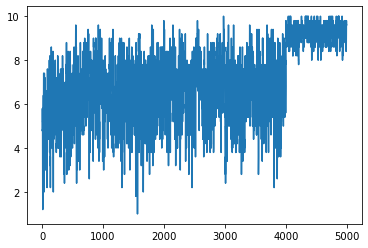

In [152]:
plt.plot(running_mean(rewards,N=5))